# Deep Embedding Clusteringを試してみたい

## 基本的なライブラリ・関数

In [1]:
# jupyter 関係
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# データ分析用
import pandas as pd
import numpy  as np
import random

# 機械学習用
import keras

# ファイル関係
import glob
import pickle
import json

# 描画関係
import matplotlib.pyplot as plt
import seaborn as sns

# カラム全表示
pd.set_option('max_columns',None)

# 小数点の設定
%precision 5

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'%.5f'

## データの取得

In [2]:
# from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# i = 100
# plt.imshow(x_train[i])
# plt.show()

# print(y_train[i])

In [4]:
DATA_PATH = "data/"

# with open(DATA_PATH+'mnist_images.pickle', 'wb') as f:
#     mnist_images = np.r_[x_train, x_test]
#     pickle.dump(mnist_images, f)

# with open(DATA_PATH+'mnist_labels.pickle', 'wb') as f:
#     mnist_labels = np.r_[y_train, y_test]
#     pickle.dump(mnist_labels, f)

## StackedAutoEncoder

### 前準備

In [5]:
from sklearn.model_selection import train_test_split

In [10]:
# データの読み込み
with open(DATA_PATH+'mnist_images.pickle', 'rb') as f:
    mnist_images = pickle.load(f)
    mnist_images = mnist_images.reshape(mnist_images.shape[0], -1)
    mnist_images = mnist_images / 255.0

with open(DATA_PATH+'mnist_labels.pickle', 'rb') as f:
    mnist_labels = pickle.load(f)
    mnist_labels = mnist_labels.reshape(mnist_labels.shape[0])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(mnist_images, mnist_labels, test_size=0.2, random_state=1000)

### モデル

In [18]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.initializers import glorot_normal

In [19]:
def StackedAutoEncoder(dims, dropout=True):
    '''
    dimsに従った次元を設定し長ならStackedAutoEncoder
    dims[0] : 入力次元
    '''
    input_data = Input(shape=(dims[0],), name="input")
    X = input_data
#     print("input : {}".format(X.shape))
    n_stack = len(dims) -1 
    initializer = glorot_normal(seed=10000)
    ### Encoder
    for i in range(n_stack):
        if i != n_stack - 1:
            # Stacked Encoder
            if dropout:
                X = Dense(dims[i+1], activation="relu", kernel_initializer=initializer, name="encoder_%d" % i)(X)
                X = Dropout(0.2)(X)
            else:
                X = Dense(dims[i+1], activation="relu", kernel_initializer=initializer, name="encoder_%d" % i)(X)
        else:
            # Encoded Features
            encoded = Dense(dims[i+1], kernel_initializer=initializer, name="encoded_features")(X)
            X = encoded
#         print("encoder_{} : {}".format(i, X.shape))

    ### Decoder
    for i in range(n_stack+1):
        if i != n_stack:
            # Stacked Decoder
            if dropout:
                X = Dense(dims[n_stack-i], activation="relu", kernel_initializer=initializer, name="decoder_%d" % i)(X)
                X = Dropout(0.2)(X)
            else:
                X = Dense(dims[n_stack-i], activation="relu", kernel_initializer=initializer, name="decoder_%d" % i)(X)
        else:
            # Reconstructed Data
            reconstructed = Dense(dims[n_stack-i], kernel_initializer=initializer, name="reconstructed_data")(X)
            X = reconstructed
#         print("decoder_{} : {}".format(i, X.shape))
    
    autoencoder = Model(inputs=input_data, outputs=reconstructed, name="AE")
    encoder = Model(inputs=input_data, outputs=encoded, name="encoder")

    return autoencoder, encoder

In [20]:
dims = [X_train.shape[-1], 500, 500, 2000, 10]
autoencoder, encoder = StackedAutoEncoder(dims)

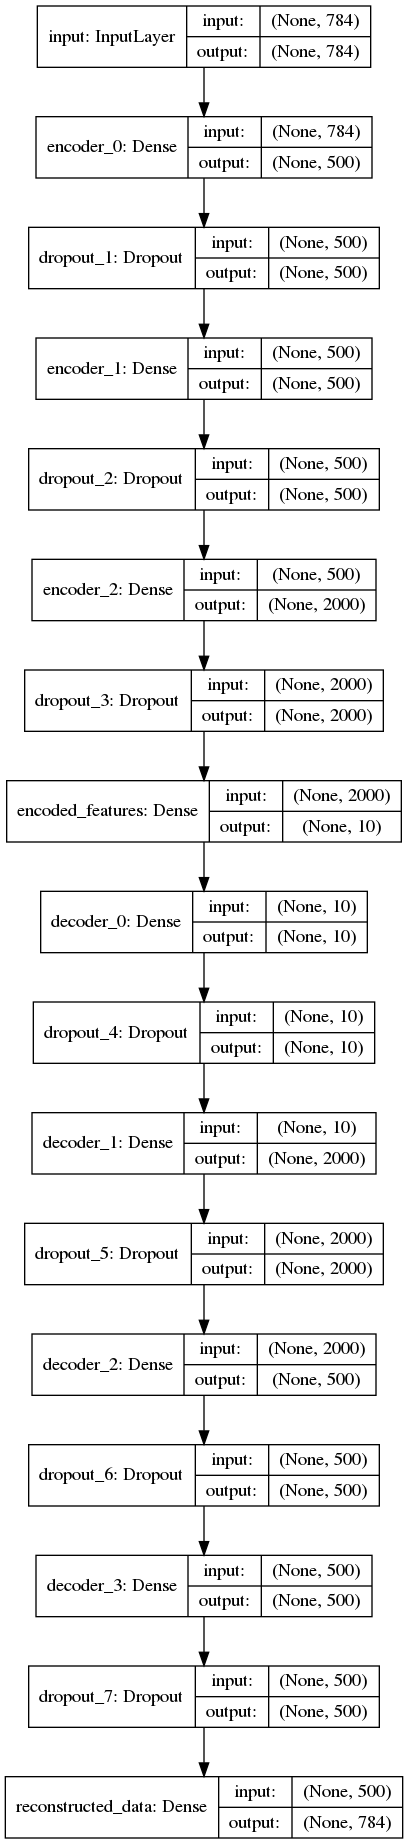

In [21]:
from keras.utils import plot_model
plot_model(autoencoder, to_file="images/autoencoder.png", show_shapes=True)

from IPython.display import Image
Image(filename="images/autoencoder.png")

### 事前学習

In [22]:
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler, EarlyStopping

In [23]:
# 学習率を少しずつ下げるようにする
def train(model, inputs, targets, X_val, Y_val, batch_size=100, epoch_count=100, 
              model_path="models/model.h5", learning_rate=0.01):
    # 学習率
    start = learning_rate
    stop = learning_rate * (1/epoch_count)
    learning_rates = np.linspace(start, stop, epoch_count)

    # 最適化手法
#     optimizer = Adam(lr=learning_rate)
    optimizer = SGD(lr=1, momentum=0.9)
    model.compile(loss="mse", optimizer=optimizer)

    # 学習
    fit = model.fit(inputs, targets, 
                        validation_data=(X_val, Y_val),
                        epochs=epoch_count,
                        batch_size=batch_size,
                        verbose=1,
                        shuffle=True,
#                         callbacks=[LearningRateScheduler(lambda epoch: learning_rates[epoch]),]
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')]
                )

    # モデルの保存
    model.save(model_path)
    
    return fit

In [77]:
MODEL_PATH = "models/"
dims = [X_train.shape[-1], 500, 500, 2000, 10]
autoencoder, encoder = StackedAutoEncoder(dims, dropout=False)

fit = train(autoencoder, X_train, X_train, X_test, X_test, 300, 300, model_path=MODEL_PATH+"pretrained_ae_300.h5")
encoder.save(MODEL_PATH+"pretrained_encoder_300.h5")

Train on 56000 samples, validate on 14000 samples
Epoch 1/300
56000/56000 [==============================] - 3s 62us/step - loss: 0.0668 - val_loss: 0.0573
Epoch 2/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0518 - val_loss: 0.0457
Epoch 3/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0409 - val_loss: 0.0376
Epoch 4/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0356 - val_loss: 0.0336
Epoch 5/300
56000/56000 [==============================] - 3s 52us/step - loss: 0.0321 - val_loss: 0.0308
Epoch 6/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0298 - val_loss: 0.0290
Epoch 7/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0282 - val_loss: 0.0276
Epoch 8/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0269 - val_loss: 0.0264
Epoch 9/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0257 - val_loss: 0.0

56000/56000 [==============================] - 3s 51us/step - loss: 0.0134 - val_loss: 0.0143
Epoch 78/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0134 - val_loss: 0.0142
Epoch 79/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0133 - val_loss: 0.0141
Epoch 80/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0132 - val_loss: 0.0141
Epoch 81/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0132 - val_loss: 0.0141
Epoch 82/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0132 - val_loss: 0.0141
Epoch 83/300
56000/56000 [==============================] - 3s 51us/step - loss: 0.0131 - val_loss: 0.0140
Epoch 84/300
56000/56000 [==============================] - 3s 52us/step - loss: 0.0131 - val_loss: 0.0140
Epoch 85/300
56000/56000 [==============================] - 3s 52us/step - loss: 0.0130 - val_loss: 0.0140
Epoch 86/300
56000/56000 [========================

56000/56000 [==============================] - 3s 53us/step - loss: 0.0111 - val_loss: 0.0126
Epoch 154/300
56000/56000 [==============================] - 3s 53us/step - loss: 0.0111 - val_loss: 0.0125
Epoch 155/300
56000/56000 [==============================] - 3s 54us/step - loss: 0.0110 - val_loss: 0.0125
Epoch 156/300
56000/56000 [==============================] - 3s 54us/step - loss: 0.0110 - val_loss: 0.0125
Epoch 157/300
56000/56000 [==============================] - 3s 54us/step - loss: 0.0110 - val_loss: 0.0125


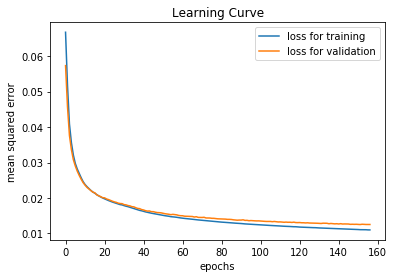

In [78]:
# 学習曲線
plt.plot(fit.history['loss'],label="loss for training")
plt.plot(fit.history["val_loss"], label="loss for validation")
plt.title("Learning Curve")
plt.xlabel("epochs")
plt.ylabel("mean squared error")
plt.legend()
plt.show()

## DeepEmbeddingClustering

### 前準備

In [79]:
from keras.models import load_model
from sklearn.cluster import KMeans

from keras import backend as K
from keras.engine.topology import Layer, InputSpec

### モデル

In [80]:
class ClusteringLayer(Layer):
    '''
    t分布に従ってソフトクラスタリングするレイヤー
    '''
    # お作法
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)
        
    # お作法
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer = glorot_normal(seed=10000),
                                                        name='clusters')
        # centroidの初期化
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    # ここで初めて処理を書く
    def call(self, inputs, mask=None):
        # centroidに従ってソフトクラスタリングするところ
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = q / K.expand_dims(K.sum(q, axis=1), axis=1)
        return q

    # お作法
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    # お作法
    def get_config(self):
        config = {'output_dim': self.output_dim,
                      'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [81]:
def auxilliary_distribution(q):
    '''
    教師無し学習なので仮想的な正解分布を作る
    '''
    p = q ** 2 / q.sum(0)
    p = p / p.sum(axis=1)[:, np.newaxis]
    return p

### 学習

In [82]:
def train_clustering(inputs, batch_size=300, num_epochs=100, pretrained_model_path="models/pretrained_encoder.h5",
                                    model_path="models/model.h5"):
    
    # この時点ではpre_trainedモデルはcompileされていない
    pre_encoder = load_model(pretrained_model_path)
    clustering_layer = ClusteringLayer(n_clusters=10, name="clustering")(pre_encoder.output)
    dec = Model(inputs=pre_encoder.input, outputs=clustering_layer)

    # centroidsの初期化
    print("Initializing Centroids")
    kmeans = KMeans(n_clusters=10, n_init=20)
    y_pred_last = kmeans.fit_predict(pre_encoder.predict(inputs))
    initial_centroids = kmeans.cluster_centers_
    dec.get_layer(name="clustering").set_weights([initial_centroids])
    
    # 学習
    print("Start Training")
    dec.compile(optimizer=SGD(0.01, 0.9), loss="kld")
    index_array = np.arange(inputs.shape[0])
    loss = 0
    for epoch in range(num_epochs):
        # p, qを計算する
        q = dec.predict(inputs, verbose=0)
        p = auxilliary_distribution(q)
        y_pred = q.argmax(1)
        print('epoch : {} / {}, loss : {:.3f}, '.format(epoch+1, num_epochs, loss), end="")

        # クラスタの移動割合を計算
        change_ratio = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if epoch > 0 and change_ratio < 0.001:
            print("{:.3f} % samples moved".format(change_ratio*100))
            print('End Training.')
            break
        else:
            print("{:.3f} % samples moved".format(change_ratio*100))
            
        # batch学習
        np.random.shuffle(index_array)
        num_batch = inputs.shape[0] // batch_size
        losses = []
        for i in range(num_batch+1):
            idx = index_array[i*batch_size:(i+1)*batch_size]
            losses.append(dec.train_on_batch(x=inputs[idx], y=p[idx]))
        loss = sum(losses) / len(losses)
    dec.save_weights(MODEL_PATH + 'DEC_model_final_300.h5')
    return dec

In [83]:
dec = train_clustering(X_train, pretrained_model_path=MODEL_PATH+"pretrained_encoder_300.h5",
                                       model_path=MODEL_PATH+"DEC_300.h5")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initializing Centroids
Start Training
epoch : 1 / 100, loss : 0.000, 0.000 % samples moved
epoch : 2 / 100, loss : 0.076, 4.582 % samples moved
epoch : 3 / 100, loss : 0.190, 3.239 % samples moved
epoch : 4 / 100, loss : 0.238, 1.748 % samples moved
epoch : 5 / 100, loss : 0.243, 1.095 % samples moved
epoch : 6 / 100, loss : 0.238, 0.838 % samples moved
epoch : 7 / 100, loss : 0.231, 0.623 % samples moved
epoch : 8 / 100, loss : 0.223, 0.525 % samples moved
epoch : 9 / 100, loss : 0.215, 0.393 % samples moved
epoch : 10 / 100, loss : 0.207, 0.382 % samples moved
epoch : 11 / 100, loss : 0.200, 0.391 % samples moved
epoch : 12 / 100, loss : 0.194, 0.289 % samples moved
epoch : 13 / 100, loss : 0.187, 0.252 % samples moved
epoch : 14 / 100, loss : 0.182, 0.246 % samples moved
epoch : 15 / 100, loss : 0.177, 0.245 % samples moved
epoch : 16 / 100, loss : 0.172, 0.209 % samples moved
epoch : 17 / 100, loss : 0.167, 0.289 % samples moved
epoch : 18 / 100, loss : 0.163, 0.286 % samples moved

### 評価

In [84]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [85]:
def predict_label(pred, groupby_counts):
    '''
   予測されたlabelと 実際のlabelを合わせる。
   予測されたlabelは分類はしているものの適当
    '''
    pred_label = np.copy(pred)
    for i in range(groupby_counts.shape[0]):
        tmp_label = np.argmax(groupby_counts[i, :])
        pred_label[pred==i] = tmp_label
    return pred_label

In [86]:
### train
# 予測
train_pred = np.argmax(dec.predict(X_train), axis=1)
y_train = y_train.reshape(-1)
# ラベルペアごとにカウント
groupby_counts_train = np.zeros((10, 10)).astype(np.int32)
for tmp_label in range(10):
    for true_label in range(10):
        groupby_counts_train[tmp_label][true_label] = int(len(np.where((train_pred == tmp_label)&(y_train==true_label))[0]))
# ラベル振り分け
train_pred = predict_label(train_pred, groupby_counts_train)

### test
# 予測
test_pred = np.argmax(dec.predict(X_test), axis=1)
y_test = y_test.reshape(-1)
# ラベルごとにカウント
groupby_counts_test = np.zeros((10, 10)).astype(np.int32)
for tmp_label in range(10):
    for true_label in range(10):
        groupby_counts_test[tmp_label][true_label] = int(len(np.where((test_pred == tmp_label)&(y_test==true_label))[0]))
# ラベル振り分け
test_pred = predict_label(test_pred, groupby_counts_test)

acc : 0.8117678571428572


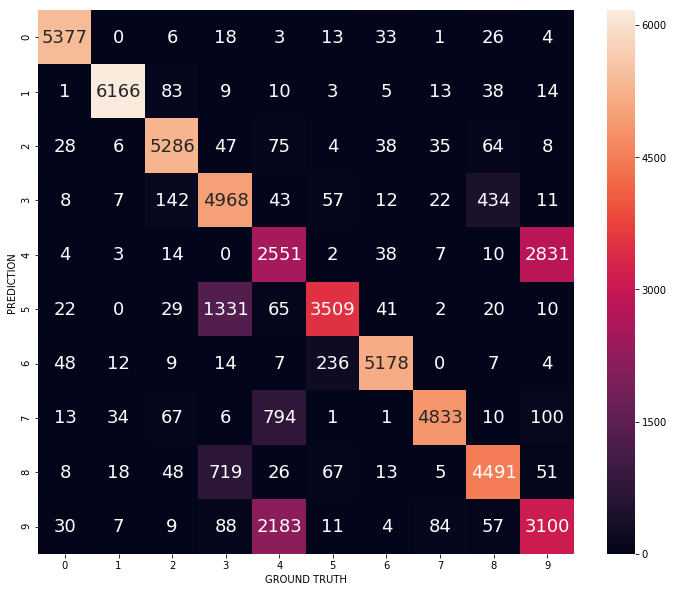

In [87]:
# train
plt.figure(figsize=(12, 10))
cfm = confusion_matrix(y_train, train_pred)
print("acc : {}".format(accuracy_score(y_train, train_pred)))
sns.heatmap(cfm, annot=True, fmt="d", annot_kws={"size":18})
plt.ylabel("PREDICTION")
plt.xlabel("GROUND TRUTH")
plt.show()

acc : 0.8081428571428572


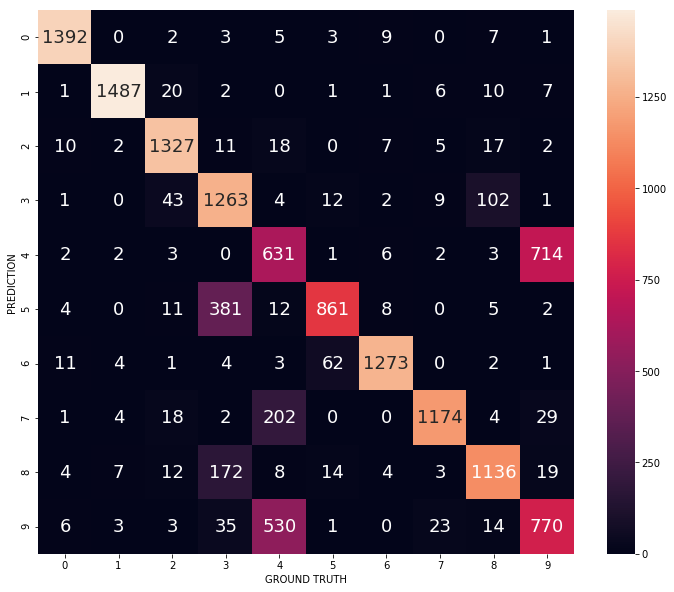

In [88]:
# test
plt.figure(figsize=(12, 10))
cfm = confusion_matrix(y_test, test_pred)
print("acc : {}".format(accuracy_score(y_test, test_pred)))
sns.heatmap(cfm, annot=True, fmt="d", annot_kws={"size":18})
plt.ylabel("PREDICTION")
plt.xlabel("GROUND TRUTH")
plt.show()